In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Importing widgets for interactive display
import ipywidgets as widgets
from IPython.display import display

# Importing Natural Language Processing (NLP) libraries
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim.models.phrases import Phrases, Phraser
from nltk import FreqDist
from textblob import TextBlob
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

# Importing machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


In [3]:
drug_test = pd.read_csv('D:\case_study\drug_review\drugsComTest_raw.tsv', sep='\t')
drug_train = pd.read_csv('D:\case_study\drug_review\drugsComTrain_raw.tsv', sep='\t')

In [4]:
#For text analytics not requiring prediction, I've combined these two dataset together
data = pd.concat([drug_train,drug_test])

In [5]:
# Displaying the shape of the training and testing datasets
print("Train shape :" ,drug_train.shape)
print("Test shape :", drug_test.shape)

Train shape : (161297, 7)
Test shape : (53766, 7)


In [6]:
drug_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [7]:
print(data.isnull().any())

Unnamed: 0     False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool


In [8]:
duplicates = data[data.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [Unnamed: 0, drugName, condition, review, rating, date, usefulCount]
Index: []


In [9]:
data.max()

Unnamed: 0                                                232291
drugName                                                pHisoHex
review         "❤️❤️❤️ Cialis for US!!    I wish I had my hus...
rating                                                      10.0
date                                           September 9, 2017
usefulCount                                                 1291
dtype: object

##### The following code checks if 'Unnamed: 0' is a unique identifier for drug names and conditions. It appears that it's not unique and is likely an identifier for each review, so we refer to it as such.

In [10]:

drug_test[(drug_test['condition'].str.contains('Cold Sores',na = False)) & (drug_test['drugName'].str.contains('Denavir', na = False)) ] 

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
2249,150088,Denavir,Cold Sores,"""Best medicine ever!! Have been using it for y...",10.0,"March 10, 2016",9
8824,150096,Denavir,Cold Sores,"""I&#039;m only 16 but I&#039;ve been getting c...",10.0,"June 8, 2015",5
10904,150069,Denavir,Cold Sores,"""I&#039;ve gotten cold sores since childhood 4...",10.0,"December 4, 2012",9
33789,150100,Denavir,Cold Sores,"""Pain is decreased as well as time of breakout...",10.0,"December 22, 2013",9
34349,150074,Denavir,Cold Sores,"""I&#039;ve had cold sores since I was young an...",10.0,"July 8, 2010",10


In [11]:
# Renaming the 'Unnamed: 0' column to 'Unique id' in both the training and testing data
drug_train.rename(columns={'Unnamed: 0': 'Unique id'}, inplace=True)
drug_test.rename(columns={'Unnamed: 0': 'Unique id'}, inplace=True)

In [12]:
# Exploring the data starting with the 'Unique id' variable to check for duplicate reviews by customers
# Comparing the number of unique IDs with the length of the training data to ensure there are no duplicate reviews by the same
print("unique id counts : " ,len(set(drug_train['Unique id'].values)))
print("length of train : " ,drug_train.shape[0])

unique id counts :  161297
length of train :  161297


In [13]:
# Checking if there are any duplicated 'Unique id' values in the training data
drug_train['Unique id'].duplicated().any()

False

In [14]:
data.dtypes 

Unnamed: 0       int64
drugName        object
condition       object
review          object
rating         float64
date            object
usefulCount      int64
dtype: object

In [15]:
#Converting date column to relevant data type
data['date'] = pd.to_datetime(data['date'])

In [16]:
#Creating dataset with relevant condition only
data_viz = data.dropna(subset=['condition'])
data_viz = data_viz[~data_viz['condition'].str.contains('users found this comment helpful')]
data_viz = data_viz[~data_viz['condition'].str.contains('Not Listed')]

In [17]:
# Calculate the number of rows in the filtered data
filtered_rows = len(data_viz)

# Calculate the total number of rows in the entire dataset
total_rows = len(data)

# Calculate the percentage of filtered data over the entire dataset
percentage_filtered = (1-(filtered_rows / total_rows) )* 100

# Print the result
print(f"The unwanted data represents {percentage_filtered:.2f}% of the entire dataset.")


The unwanted data represents 1.37% of the entire dataset.


In [18]:
#Can replace the current data with the filtered data
data = data_viz

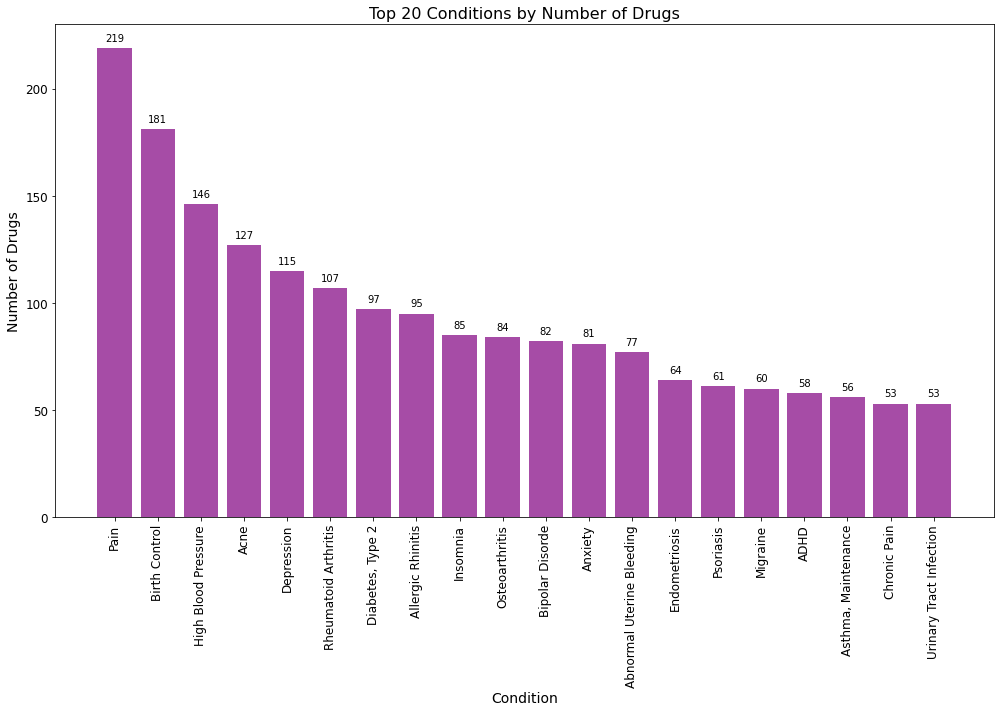

In [19]:
# Calculating the number of unique drugs per condition and selecting the top 20
condition_top = data.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
top_20 = condition_top.head(20)

# Resetting the index to avoid the dtype conversion issue
top_20 = top_20.reset_index()

# Creating the bar plot
plt.figure(figsize=(14, 10))
plt.bar(top_20['condition'], top_20['drugName'], color='purple', alpha=0.7)
plt.xlabel("Condition", fontsize=14)
plt.ylabel("Number of Drugs", fontsize=14)
plt.title("Top 20 Conditions by Number of Drugs", fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

# Adding data labels below each bar
for i, v in enumerate(top_20['drugName']):
    plt.text(i, v + 7, str(v), ha='center', va='top', fontsize=10)  # Adjust the y-coordinate for labels below the bars

# Showing the plot
plt.tight_layout()
plt.show()


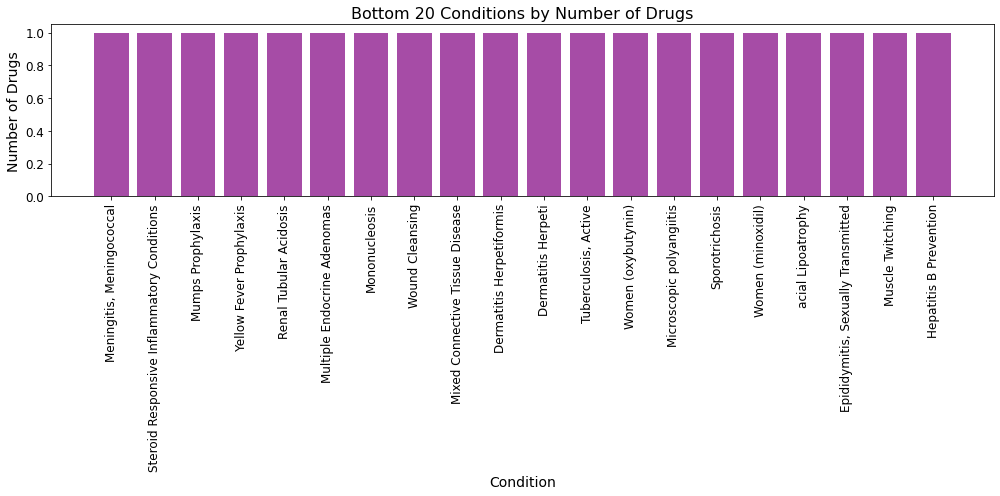

In [20]:
# Calculating the number of unique drugs per condition and selecting the bottom 20
condition_bottom = data.groupby(['condition'])['drugName'].nunique().sort_values(ascending=True)
bottom_20 = condition_bottom.head(20)

# Reset the index to avoid the dtype conversion issue
bottom_20 = bottom_20.reset_index()

# Create the bar plot
plt.figure(figsize=(14, 7))
plt.bar(bottom_20['condition'], bottom_20['drugName'], color='purple', alpha=0.7)
plt.xlabel("Condition", fontsize=14)
plt.ylabel("Number of Drugs", fontsize=14)
plt.title("Bottom 20 Conditions by Number of Drugs", fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)


# Show the plot
plt.tight_layout()
plt.show()


In [24]:
# Get unique conditions
unique_conditions = data_viz['condition'].astype(str).unique()

# Create a dropdown widget for selecting condition
condition_dropdown = widgets.Dropdown(
    options=sorted(unique_conditions),
    description='Select Condition:',
)

def update_bar_chart(condition):
    filtered_data = data_viz[data_viz['condition'] == condition]
    drug_counts = filtered_data['drugName'].value_counts()
    
    plt.figure(figsize=(12, 6))
    drug_counts.plot(kind='bar', color='purple')
    plt.xlabel('Drug')
    plt.ylabel('Count of Unique ID')
    plt.title(f'Bar Chart for {condition}')
    plt.xticks(rotation=45)
    plt.show()

# Use widgets.interactive to create the dynamic link
interactive_plot = widgets.interactive(update_bar_chart, condition=condition_dropdown)

# Display the widgets
interactive_plot

interactive(children=(Dropdown(description='Select Condition:', options=('ADHD', 'AIDS Related Wasting', 'AV H…

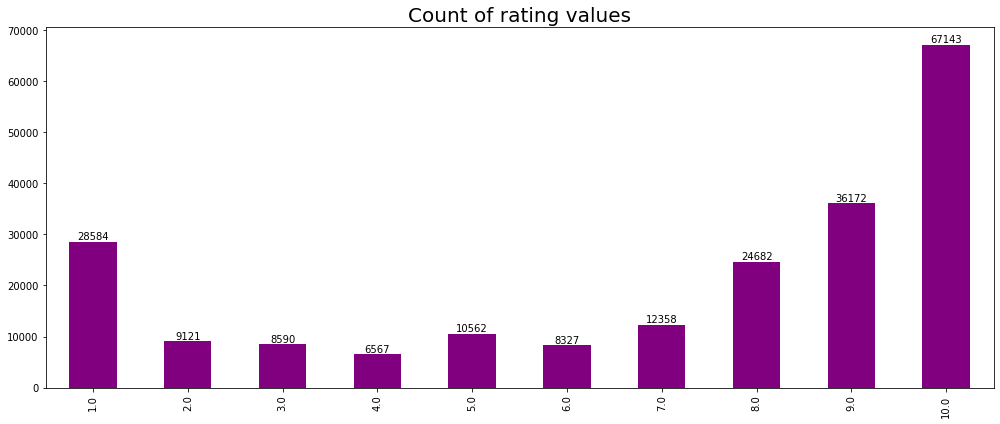

In [25]:
# Counting the occurrences of each rating
rating_counts = data['rating'].value_counts().sort_values(ascending=False)

# Creating a bar plot
bar = rating_counts.plot(kind="bar", figsize=(14, 6), fontsize=10, color="purple")
plt.xlabel("", fontsize=20)
plt.ylabel("", fontsize=20)
plt.title("Count of rating values", fontsize=20)

# Adding labels with counts above each bar
for bar, count in zip(bar.patches, rating_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 10, str(count), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [26]:
data

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,2014-09-13,43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,2016-10-08,11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,2010-11-15,7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,2011-11-28,20


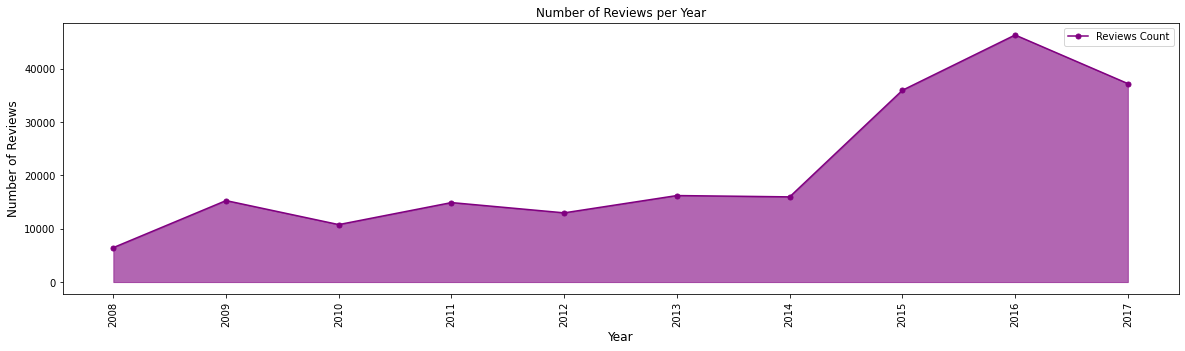

In [27]:
# Converting the 'date' column to datetime using the correct date format
data['date'] = pd.to_datetime(data['date'], format='%B %d, %Y')
data['year'] = data['date'].dt.year  # Extract year

# Calculating the count of reviews per year
cnt_srs = data['year'].value_counts().sort_index()

# Creating an area chart using Matplotlib
plt.figure(figsize=(20, 5))
plt.fill_between(cnt_srs.index, cnt_srs.values, color='purple', alpha=0.6)
plt.plot(cnt_srs.index, cnt_srs.values, color='purple', marker='o', markersize=5, label='Reviews Count')

# Set x-axis ticks to display all years
plt.xticks(cnt_srs.index, rotation='vertical')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.title('Number of Reviews per Year')
plt.legend()
plt.show()


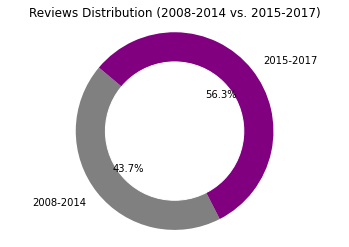

In [28]:
# Filter the data for the specified years
data_2008_to_2014 = data[data['year'].between(2008, 2014)]
data_2015_to_2017 = data[data['year'].between(2015, 2017)]

# Calculate the count of reviews for each category
count_2008_to_2014 = len(data_2008_to_2014)
count_2015_to_2017 = len(data_2015_to_2017)

# Create data for the donut chart
labels = ['2008-2014', '2015-2017']
sizes = [count_2008_to_2014, count_2015_to_2017]
colors = ['Grey', 'Purple']

# Create a pie chart for the outer circle
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, labeldistance=1.15)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add a circle in the center to make it a donut chart
circle = plt.Circle((0, 0), 0.7, color='white')
fig = plt.gcf()
fig.gca().add_artist(circle)

# Add a title
plt.title('Reviews Distribution (2008-2014 vs. 2015-2017)')

# Display the chart
plt.show()


In [29]:
data['date'].min()

Timestamp('2008-02-24 00:00:00')

In [30]:
data['review_copy'] = data['review'].str.lower()
data['review_copy'] = data['review_copy'].str.replace('[^\w\s]', '')

<ipython-input-30-4e2036ddbbc2>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['review_copy'] = data['review_copy'].str.replace('[^\w\s]', '')


In [31]:

# Converting to lowercase
data['review'] = data['review'].str.lower()

# Removing punctuation
data['review'] = data['review'].str.replace('[^\w\s]', '')

# Handling Whitespaces
# 1. Removing extra whitespaces (including leading and trailing whitespaces)
data['review'] = data['review'].str.strip()

# 2. Normalizing multiple spaces to a single space
data['review'] = data['review'].str.replace('\s+', ' ')

# Tokenization (split text into words)
data['review'] = data['review'].apply(nltk.word_tokenize)


<ipython-input-31-b26995d8a416>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data['review'] = data['review'].str.replace('[^\w\s]', '')
<ipython-input-31-b26995d8a416>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  data['review'] = data['review'].str.replace('\s+', ' ')


In [32]:
stop_words = set(stopwords.words('english'))

data['review'] = data['review'].apply(lambda x: [word for word in x if word not in stop_words])


In [103]:
# Defining a regular expression pattern to match words containing '039'
pattern = re.compile(r'.*039.*')

def remove_words_containing_039(text):
    return [word for word in text if not pattern.match(word)]

data['review'] = data['review'].apply(remove_words_containing_039)


In [34]:
data

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,year,review_copy
0,206461,Valsartan,Left Ventricular Dysfunction,"[side, effect, take, combination, bystolic, 5,...",9.0,2012-05-20,27,2012,it has no side effect i take it in combination...
1,95260,Guanfacine,ADHD,"[son, halfway, fourth, week, intuniv, became, ...",8.0,2010-04-27,192,2010,my son is halfway through his fourth week of i...
2,92703,Lybrel,Birth Control,"[used, take, another, oral, contraceptive, 21,...",5.0,2009-12-14,17,2009,i used to take another oral contraceptive whic...
3,138000,Ortho Evra,Birth Control,"[first, time, using, form, birth, control, gla...",8.0,2015-11-03,10,2015,this is my first time using any form of birth ...
4,35696,Buprenorphine / naloxone,Opiate Dependence,"[suboxone, completely, turned, life, around, f...",9.0,2016-11-27,37,2016,suboxone has completely turned my life around ...
...,...,...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","[taken, tamoxifen, 5, years, side, effects, se...",10.0,2014-09-13,43,2014,i have taken tamoxifen for 5 years side effect...
53762,140714,Escitalopram,Anxiety,"[taking, lexapro, escitaploprgram, since, febr...",9.0,2016-10-08,11,2016,i039ve been taking lexapro escitaploprgram sin...
53763,130945,Levonorgestrel,Birth Control,"[married, 34, years, old, kids, taking, pill, ...",8.0,2010-11-15,7,2010,i039m married 34 years old and i have no kids ...
53764,47656,Tapentadol,Pain,"[prescribed, nucynta, severe, neckshoulder, pa...",1.0,2011-11-28,20,2011,i was prescribed nucynta for severe neckshould...


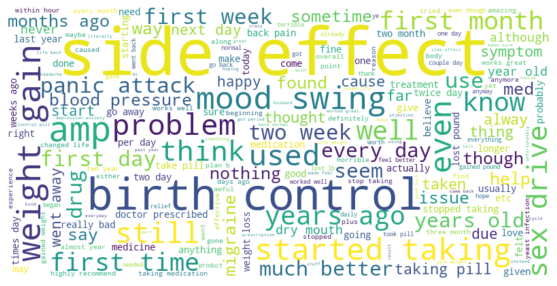

In [35]:
# Combining all the reviews into a single string
all_reviews = ' '.join([' '.join(review) for review in data['review']])

# Creating a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# Bigrams/Trigrams

# Word Frequency Analysis

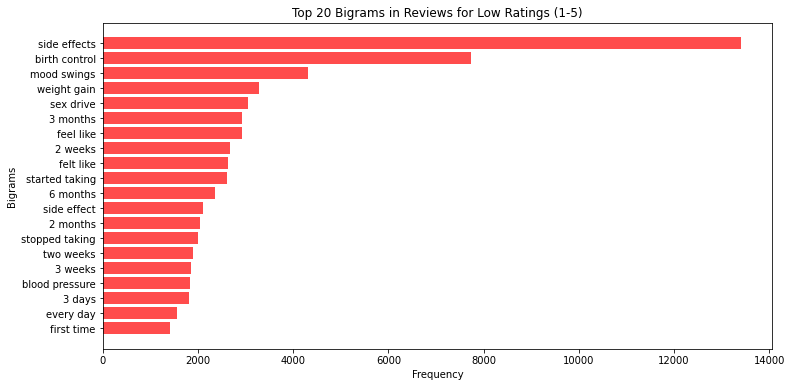

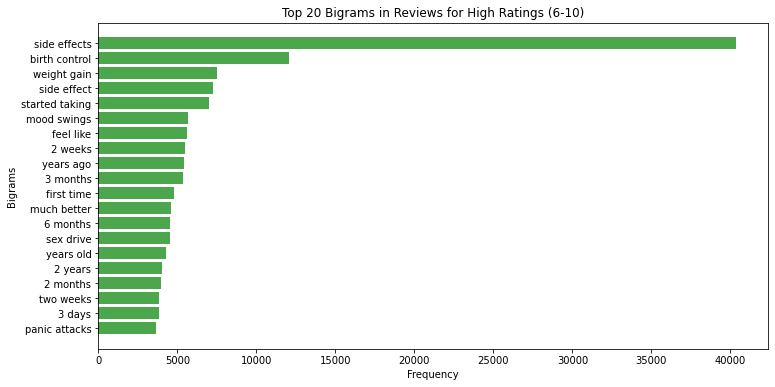

In [36]:
# Creating separate dataframes for ratings 1-5 and 6-10
df_low_ratings = data[data['rating'] <= 5]
df_high_ratings = data[data['rating'] >= 6]

# Function to generate bigrams from a list of words
def generate_bigrams(words_list):
    bigrams = list(nltk.bigrams(words_list))
    return [' '.join(bigram) for bigram in bigrams]

# Calculating bigram frequencies for low ratings (1-5)
all_bigrams_low_ratings = [bigram for words in df_low_ratings['review'].apply(generate_bigrams) for bigram in words]
bigram_freq_low_ratings = FreqDist(all_bigrams_low_ratings)

# Calculating bigram frequencies for high ratings (6-10)
all_bigrams_high_ratings = [bigram for words in df_high_ratings['review'].apply(generate_bigrams) for bigram in words]
bigram_freq_high_ratings = FreqDist(all_bigrams_high_ratings)

# Getting the top N bigrams for each group
top_n = 20  # Can adjust the value as needed
top_bigrams_low_ratings = bigram_freq_low_ratings.most_common(top_n)
top_bigrams_high_ratings = bigram_freq_high_ratings.most_common(top_n)

# Extracting bigrams and frequencies for plotting
bigrams_low_ratings, freq_low_ratings = zip(*top_bigrams_low_ratings)
bigrams_high_ratings, freq_high_ratings = zip(*top_bigrams_high_ratings)

# Creating a bar chart for top bigrams in low ratings (1-5)
plt.figure(figsize=(12, 6))
plt.barh(bigrams_low_ratings, freq_low_ratings, color='red', alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top {} Bigrams in Reviews for Low Ratings (1-5)'.format(top_n))
plt.gca().invert_yaxis()  # Invert the y-axis to display most frequent bigrams at the top
plt.show()

# Creating a bar chart for top bigrams in high ratings (6-10)
plt.figure(figsize=(12, 6))
plt.barh(bigrams_high_ratings, freq_high_ratings, color='green', alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top {} Bigrams in Reviews for High Ratings (6-10)'.format(top_n))
plt.gca().invert_yaxis()  # Invert the y-axis to display most frequent bigrams at the top
plt.show()


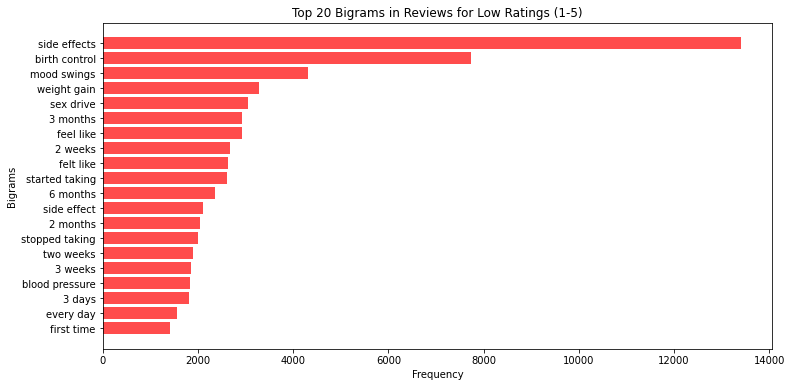

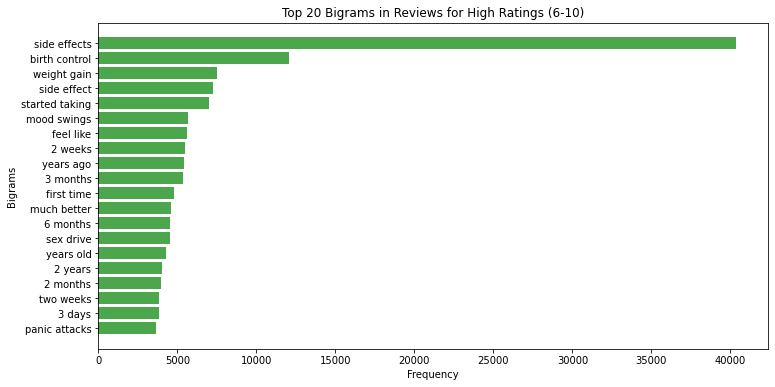

In [37]:
# Creating separate DataFrames for ratings 1-5 and 6-10
df_low_ratings = data[data['rating'] <= 5]
df_high_ratings = data[data['rating'] >= 6]

# Initiating a function to generate bigrams from a list of words
def generate_bigrams(words_list):
    bigrams = list(nltk.bigrams(words_list))
    return [' '.join(bigram) for bigram in bigrams]

# Calculating bigram frequencies for low ratings (1-5)
all_bigrams_low_ratings = [bigram for words in df_low_ratings['review'].apply(generate_bigrams) for bigram in words]
bigram_freq_low_ratings = FreqDist(all_bigrams_low_ratings)

# Calculating bigram frequencies for high ratings (6-10)
all_bigrams_high_ratings = [bigram for words in df_high_ratings['review'].apply(generate_bigrams) for bigram in words]
bigram_freq_high_ratings = FreqDist(all_bigrams_high_ratings)

# Setting the value for the top N bigrams, which can be adjusted as needed
top_n = 20

# Extracting the top bigrams and their frequencies for both groups
top_bigrams_low_ratings = bigram_freq_low_ratings.most_common(top_n)
top_bigrams_high_ratings = bigram_freq_high_ratings.most_common(top_n)

# Extracting bigrams and their frequencies for plotting
bigrams_low_ratings, freq_low_ratings = zip(*top_bigrams_low_ratings)
bigrams_high_ratings, freq_high_ratings = zip(*top_bigrams_high_ratings)

# Creating a bar chart for the top bigrams in low ratings (1-5)
plt.figure(figsize=(12, 6))
plt.barh(bigrams_low_ratings, freq_low_ratings, color='red', alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top {} Bigrams in Reviews for Low Ratings (1-5)'.format(top_n))
plt.gca().invert_yaxis()  # Inverting the y-axis to display the most frequent bigrams at the top
plt.show()

# Creating a bar chart for the top bigrams in high ratings (6-10)
plt.figure(figsize=(12, 6))
plt.barh(bigrams_high_ratings, freq_high_ratings, color='green', alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top {} Bigrams in Reviews for High Ratings (6-10)'.format(top_n))
plt.gca().invert_yaxis()  # Inverting the y-axis to display the most frequent bigrams at the top
plt.show()


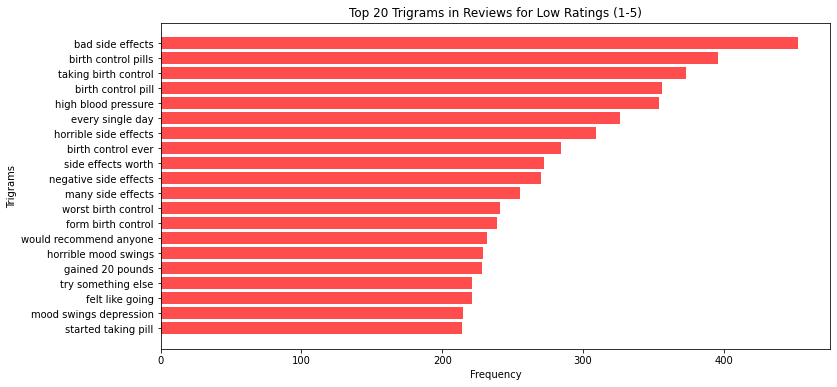

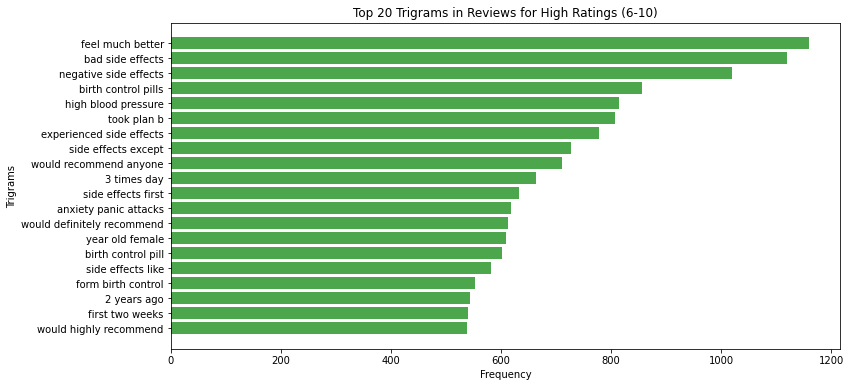

In [38]:


# Create separate dataframes for ratings 1-5 and 6-10
df_low_ratings = data[data['rating'] <= 5]
df_high_ratings = data[data['rating'] >= 6]

# Function to generate trigrams from a list of words
def generate_trigrams(words_list):
    trigrams = list(nltk.trigrams(words_list))
    return [' '.join(trigram) for trigram in trigrams]

# Calculate trigram frequencies for low ratings (1-5)
all_trigrams_low_ratings = [trigram for words in df_low_ratings['review'].apply(generate_trigrams) for trigram in words]
trigram_freq_low_ratings = FreqDist(all_trigrams_low_ratings)

# Calculate trigram frequencies for high ratings (6-10)
all_trigrams_high_ratings = [trigram for words in df_high_ratings['review'].apply(generate_trigrams) for trigram in words]
trigram_freq_high_ratings = FreqDist(all_trigrams_high_ratings)

# Get the top N trigrams for each group
top_n = 20  # Adjust this value to display more or fewer trigrams
top_trigrams_low_ratings = trigram_freq_low_ratings.most_common(top_n)
top_trigrams_high_ratings = trigram_freq_high_ratings.most_common(top_n)

# Extract trigrams and frequencies for plotting
trigrams_low_ratings, freq_low_ratings = zip(*top_trigrams_low_ratings)
trigrams_high_ratings, freq_high_ratings = zip(*top_trigrams_high_ratings)

# Create a bar chart for top trigrams in low ratings (1-5)
plt.figure(figsize=(12, 6))
plt.barh(trigrams_low_ratings, freq_low_ratings, color='red', alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.title('Top {} Trigrams in Reviews for Low Ratings (1-5)'.format(top_n))
plt.gca().invert_yaxis()  # Invert the y-axis to display most frequent trigrams at the top
plt.show()

# Create a bar chart for top trigrams in high ratings (6-10)
plt.figure(figsize=(12, 6))
plt.barh(trigrams_high_ratings, freq_high_ratings, color='green', alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.title('Top {} Trigrams in Reviews for High Ratings (6-10)'.format(top_n))
plt.gca().invert_yaxis()  # Invert the y-axis to display most frequent trigrams at the top
plt.show()


# Sentiment Analysis

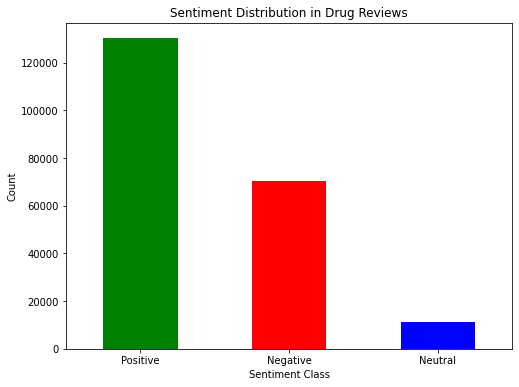

Overall Sentiment Distribution:
Positive    0.614419
Negative    0.332324
Neutral     0.053256
Name: sentiment_class, dtype: float64


In [39]:
# Calculate sentiment scores for each review
data['sentiment'] = data['review'].apply(lambda x: TextBlob(' '.join(x)).sentiment)

# Extract the polarity (positive/negative) score
data['polarity_sentiment'] = data['sentiment'].apply(lambda x: x.polarity)

# Function to classify sentiment
def classify_sentiment(polarity_score):
    if polarity_score > 0:
        return 'Positive'
    elif polarity_score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment classification
data['sentiment_class'] = data['polarity_sentiment'].apply(classify_sentiment)

# Visualize sentiment distribution
sentiment_counts = data['sentiment_class'].value_counts()
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution in Drug Reviews')
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Calculate overall sentiment distribution
overall_sentiment = data['sentiment_class'].value_counts(normalize=True)
print("Overall Sentiment Distribution:")
print(overall_sentiment)


In [40]:
data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,year,review_copy,sentiment,polarity_sentiment,sentiment_class
0,206461,Valsartan,Left Ventricular Dysfunction,"[side, effect, take, combination, bystolic, 5,...",9.0,2012-05-20,27,2012,it has no side effect i take it in combination...,"(0.0, 0.0)",0.000000,Neutral
1,95260,Guanfacine,ADHD,"[son, halfway, fourth, week, intuniv, became, ...",8.0,2010-04-27,192,2010,my son is halfway through his fourth week of i...,"(0.14861111111111114, 0.43657407407407406)",0.148611,Positive
2,92703,Lybrel,Birth Control,"[used, take, another, oral, contraceptive, 21,...",5.0,2009-12-14,17,2009,i used to take another oral contraceptive whic...,"(0.11980519480519483, 0.4127705627705628)",0.119805,Positive
3,138000,Ortho Evra,Birth Control,"[first, time, using, form, birth, control, gla...",8.0,2015-11-03,10,2015,this is my first time using any form of birth ...,"(0.2625, 0.6187499999999999)",0.262500,Positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"[suboxone, completely, turned, life, around, f...",9.0,2016-11-27,37,2016,suboxone has completely turned my life around ...,"(0.19444444444444445, 0.40138888888888885)",0.194444,Positive


# TEXT CLASSIFICATION

In [41]:
data_class = data[['review','sentiment_class']]

In [42]:
data_class = data_class.groupby('sentiment_class').apply(lambda x: x.sample(1000)).reset_index(drop=True)
data_class.head()

,review,sentiment_class
0,"[little, relief, knee, pain]",Negative
1,"[feel, like, help, stabilize, little, bit, dep...",Negative
2,"[worked, okay, caused, fainting, spells, comin...",Negative
3,"[tooth, painful, started, 4, days, started, di...",Negative
4,"[wasted, money, nothing]",Negative


In [43]:
data_class['category_id'] = data_class['sentiment_class'].factorize()[0]
data_class

,review,sentiment_class,category_id
0,"[little, relief, knee, pain]",Negative,0
1,"[feel, like, help, stabilize, little, bit, dep...",Negative,0
2,"[worked, okay, caused, fainting, spells, comin...",Negative,0
3,"[tooth, painful, started, 4, days, started, di...",Negative,0
4,"[wasted, money, nothing]",Negative,0
...,...,...,...
2995,"[interesting, medicine, made, huge, difference...",Positive,2
2996,"[efudex, successfully, combated, skin, abnorma...",Positive,2
2997,"[er, day, slipped, disc, pinched, sciatic, ner...",Positive,2
2998,"[take, 15, mg, three, times, day, along, rital...",Positive,2


In [44]:

tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

In [45]:
# Flatten the list of lists into a list of strings
data_class['review'] = data_class['review'].apply(lambda x: ' '.join(x))

# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer()

# Fit and transform the 'review' data
features = tfidf.fit_transform(data_class['review']).toarray()

In [46]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [47]:
labels = data_class.sentiment_class
labels

0       Negative
1       Negative
2       Negative
3       Negative
4       Negative
          ...   
2995    Positive
2996    Positive
2997    Positive
2998    Positive
2999    Positive
Name: sentiment_class, Length: 3000, dtype: object

In [48]:
X_train, X_test, y_train, y_test = train_test_split(data_class['review'], data_class['sentiment_class'], random_state = 42)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [49]:
y_train.value_counts()

Positive    761
Neutral     751
Negative    738
Name: sentiment_class, dtype: int64

In [50]:
y_test.value_counts()

Negative    262
Neutral     249
Positive    239
Name: sentiment_class, dtype: int64

In [51]:
print(clf.predict(count_vect.transform(["Doctor prescribed me to take Ribovalin"])))

['Negative']


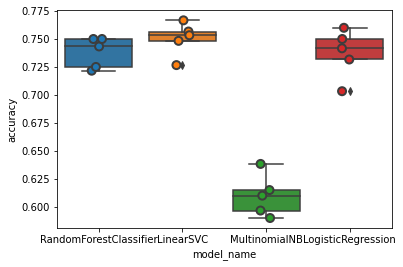

In [52]:
models = [
    RandomForestClassifier(),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [53]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.750333
LogisticRegression        0.737333
MultinomialNB             0.610000
RandomForestClassifier    0.738000
Name: accuracy, dtype: float64

In [54]:
model = LinearSVC()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.33, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [55]:
category_id_df = data_class[['sentiment_class', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'sentiment_class']].values)

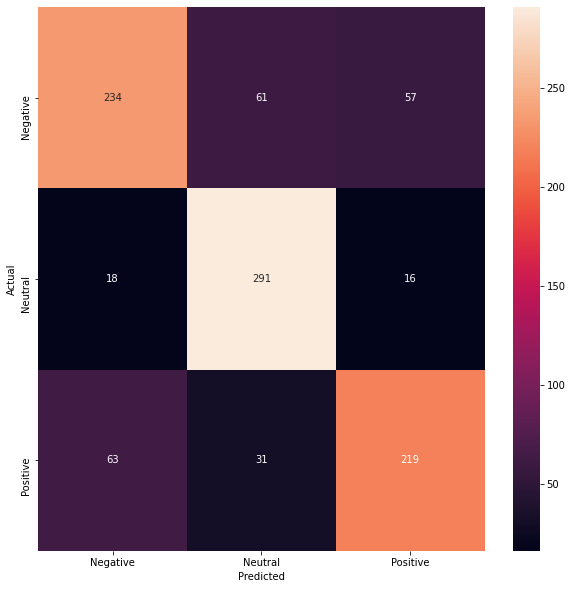

In [56]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.sentiment_class.values, yticklabels=category_id_df.sentiment_class.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [57]:
y_test


311     Negative
1025     Neutral
1587     Neutral
2941    Positive
2980    Positive
          ...   
1656     Neutral
1922     Neutral
453     Negative
1686     Neutral
2639    Positive
Name: sentiment_class, Length: 990, dtype: object

# Adverse Event Classification

In [58]:
df = pd.concat([drug_train, drug_test])

In [59]:
adverse = df[(df.review.str.lower().str.contains('side effect|adverse effect|adverse reaction'))]

In [60]:
adverse['tokens'] = adverse['review'].apply(sent_tokenize)

<ipython-input-60-85e64bf5c347>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adverse['tokens'] = adverse['review'].apply(sent_tokenize)


In [61]:
len(adverse)

54612

In [62]:
def keep_sent(row):
    all_sent=[]
    for i in range(len(row)):
        if row[i].find('side effect') != -1:
            all_sent.append(row[i])
        if row[i].find('adverse effect') != -1:
            all_sent.append(row[i])
        if row[i].find('adverse reaction') != -1:
            all_sent.append(row[i])
    return ' '.join(all_sent)

In [63]:
se_train = adverse[:300]

In [64]:
se_train = pd.read_excel('D:\case_study\se_train_marked.xlsx')
se_train.head()

<ipython-input-64-2c80028b74fe>:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  se_train = pd.read_excel('D:\case_study\se_train_marked.xlsx')


,Unnamed: 0,one_row,output
0,0,"""I used to take another oral contraceptive, wh...",0.0
1,1,I have found the side-effects to be minimal co...,0.0
2,2,Enjoyed the initial rockhard erections but not...,1.0
3,3,"Only side effect is I like to eat a lot.""",1.0
4,4,I have lost 5.2lbs so far but note I am really...,0.0


In [65]:
se_train = se_train[['one_row', 'output']]

In [66]:
se_train = se_train[se_train.output.notnull()]

In [67]:
se_train['output'] = se_train['output'].astype(int) 

In [68]:
se_train['output'] = se_train['output'].replace({1: 'positive', 0: 'negative'})
se_train.head()

,one_row,output
0,"""I used to take another oral contraceptive, wh...",negative
1,I have found the side-effects to be minimal co...,negative
2,Enjoyed the initial rockhard erections but not...,positive
3,"Only side effect is I like to eat a lot.""",positive
4,I have lost 5.2lbs so far but note I am really...,negative


In [69]:
col = ['one_row', 'output']
se_train = se_train[col]
se_train = se_train[pd.notnull(se_train['output'])]
se_train.columns = ['one_row', 'output']
se_train['category_id'] = se_train['output'].factorize()[0]
category_id_df = se_train[['output', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'output']].values)
se_train.head()

,one_row,output,category_id
0,"""I used to take another oral contraceptive, wh...",negative,0
1,I have found the side-effects to be minimal co...,negative,0
2,Enjoyed the initial rockhard erections but not...,positive,1
3,"Only side effect is I like to eat a lot.""",positive,1
4,I have lost 5.2lbs so far but note I am really...,negative,0


In [70]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

In [71]:
features = tfidf.fit_transform(se_train.one_row).toarray()

In [72]:
labels = se_train.output

In [73]:
X_train, X_test, y_train, y_test = train_test_split(se_train['one_row'], se_train['output'], random_state = 42)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [74]:
y_train.value_counts()

negative    114
positive     98
Name: output, dtype: int64

In [75]:
y_test.value_counts()

positive    45
negative    26
Name: output, dtype: int64

In [76]:
print(clf.predict(count_vect.transform(["I experienced little to no side effects"])))

['negative']


In [77]:
print(clf.predict(count_vect.transform(["I had horrible side effects a week after taking the medicines"])))

['positive']


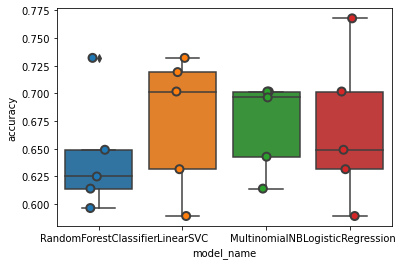

In [78]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [79]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.674812
LogisticRegression        0.667920
MultinomialNB             0.671366
RandomForestClassifier    0.643358
Name: accuracy, dtype: float64

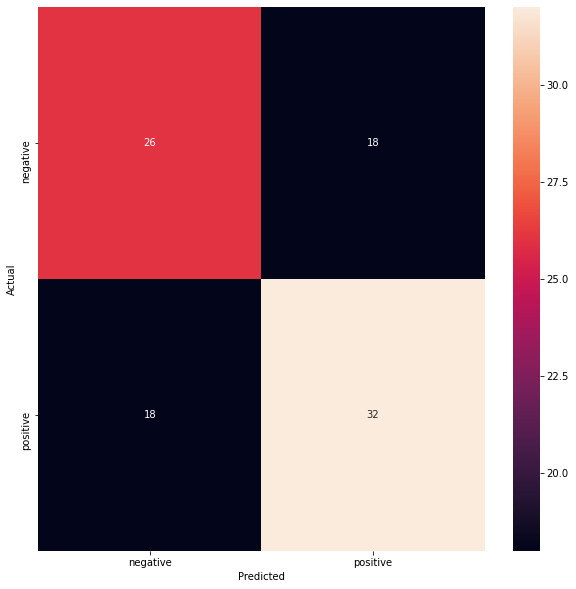

In [80]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, se_train.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.output.values, yticklabels=category_id_df.output.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [81]:
def apply_side_effect_clf(row):
    if row != None:
        clf_op = clf.predict(count_vect.transform([row]))
    else:
        return 'empty'
    return clf_op[0]

In [82]:
#Age and gender identification

In [83]:
sample = adverse[adverse.drugName == 'Lybrel'][:50]

In [84]:
sample['keep'] = sample['tokens'].apply(keep_sent)

In [85]:
sample['clf_op'] = sample['keep'].apply(apply_side_effect_clf)

In [86]:
sample['clf_op'] = sample['clf_op'].replace({'negative': 'low to medium side effects', 'positive': 'medium to high side effects'})

In [87]:
sample

,Unique id,drugName,condition,review,rating,date,usefulCount,tokens,keep,clf_op
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,"[""I used to take another oral contraceptive, w...","""I used to take another oral contraceptive, wh...",low to medium side effects
19857,92694,Lybrel,Birth Control,"""I&#039;ve been on it for about 2 weeks and I ...",8.0,"September 11, 2017",3,"[""I&#039;ve been on it for about 2 weeks and I...","""I&#039;ve been on it for about 2 weeks and I ...",low to medium side effects
95126,92702,Lybrel,Birth Control,"""I was on YAZ for about a year and it was a ho...",10.0,"February 18, 2010",44,"[""I was on YAZ for about a year and it was a h...",My mood swings are gone and I have not had any...,low to medium side effects


In [88]:
sample.clf_op.value_counts()

low to medium side effects    3
Name: clf_op, dtype: int64

# Age and gender identification

In [89]:
import spacy
from spacy.lang.en.examples import sentences 

nlp = spacy.load("en_core_web_sm")

In [90]:
def find_num(row):
    doc = nlp(row)
    for entity in doc.ents:
#     print(entity.text)
        if (entity.label_ == "DATE") or (entity.label_=='CARDINAL'):
            return entity.text

In [91]:
sample = df[df.review.str.contains('yrs old|years old|year old')].sample(500)

In [92]:
sample['numbers'] = sample['review'].apply(find_num)

In [93]:
sample.sample(20)

,Unique id,drugName,condition,review,rating,date,usefulCount,numbers
28636,141362,Escitalopram,Generalized Anxiety Disorde,"""Before Lexapro, my anxiety would take over my...",10.0,"October 19, 2014",210,only 21 years old
105210,8043,Xanax,Panic Disorde,"""I have used Xanax since 1996. I love it. It h...",10.0,"October 1, 2008",176,1996
159610,103315,Celecoxib,Osteoarthritis,"""I am 59 year old female. I have sport related...",8.0,"March 10, 2014",90,59 year old
150215,14415,Buprenorphine / naloxone,Opiate Dependence,"""I have been on Suboxone since the medicine be...",10.0,"September 21, 2010",29,15 years old
9874,120200,Homatropine / hydrocodone,Cough,"""I am an 80 year old female who hardly ever ge...",10.0,"March 15, 2012",46,80 year old
95130,118087,Apixaban,Prevention of Thromboembolism in Atrial Fibril...,"""My 93 year old mother has had 2 respiratory ...",5.0,"December 23, 2015",15,93 year old
159162,113751,Acetaminophen / butalbital / caffeine,Headache,"""Excellent for migraines. No side effects. My ...",10.0,"June 13, 2013",45,15 years old
44212,190359,Ortho Tri-Cyclen Lo,Birth Control,"""I&#039;m 19 yrs old going on 20 soon. I&#039;...",9.0,"August 26, 2012",12,19
41880,71034,Rituximab,Rheumatoid Arthritis,"""I am 55 year old male that has been diagnosed...",9.0,"January 10, 2016",33,55 year old
18396,179560,Adapalene / benzoyl peroxide,Acne,"""SO I&#039;ve suffered with acne basically sin...",9.0,"May 14, 2017",0,21 years old


In [94]:
import gender_guesser.detector as gender

In [95]:
d = gender.Detector()

In [96]:
print(d.get_gender('Nikita Pai'))

unknown


In [97]:
def get_name(row):
    ent = ''
    doc = nlp(row)
    for entity in doc.ents:
    #     print(entity.text, entity.label_)
        if (entity.label_ == "PERSON"):
            ent = entity.text
            
    return ent

In [98]:
def guess_gender(row):
    return d.get_gender(row)

In [99]:
sample['name'] = sample['review'].apply(get_name)

In [100]:
sample['gender'] = sample['name'].apply(guess_gender)

In [101]:
sample.gender.unique()

array(['unknown', 'andy', 'female', 'male'], dtype=object)

In [102]:
sample

,Unique id,drugName,condition,review,rating,date,usefulCount,numbers,name,gender
77939,200425,Varenicline,Smoking Cessation,"""I am 63 years old and have smoked about 1 pac...",8.0,"October 17, 2013",12,63 years old,,unknown
49730,56176,Humira,Ankylosing Spondylitis,"""36 year old female, diagnosed with Ankylosing...",8.0,"July 25, 2017",4,36 year old,Ankylosing Spondylitis,unknown
124668,206262,Mesalamine,"Crohn's Disease, Maintenance","""I&#039;m a Filipina 44 years old and was diag...",9.0,"November 20, 2017",0,44 years old,crohn&#039;s,unknown
81375,191664,Lisdexamfetamine,ADHD,"""I am a 32 year old. I have been on Vyvanse fo...",8.0,"June 11, 2011",11,32 year old,Straterra,unknown
29168,192737,Drospirenone / ethinyl estradiol,Birth Control,"""I&#039;m 23 years old, and started birth cont...",9.0,"October 11, 2010",7,23 years old,,unknown
...,...,...,...,...,...,...,...,...,...,...
159235,99999,Desogestrel / ethinyl estradiol,Birth Control,"""So far, I haven&#039;t had any problems with ...",10.0,"July 22, 2017",2,15 year old,,unknown
77348,53495,Onexton,Acne,"""I have never had a problem with acne until I ...",10.0,"August 9, 2017",3,20 years old,Onexton,unknown
77697,187145,Safyral,Birth Control,"""This is my first birth control pill I&#039;ve...",8.0,"May 22, 2011",2,16 years old,,unknown
68712,40169,Amiodarone,Ventricular Tachycardia,"""After failed ablations, as well as trying vir...",9.0,"April 17, 2011",35,13 year,ventricular tachycardia,unknown
